In [26]:
from time import perf_counter as pc
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import pandas as pd

%matplotlib inline

In [5]:
import develop

# Adjoint-based Data Assimilation
J. Sesternhenn, University of Bauereuth - 28th of March 2020

## Nomenclature
| Symbol | Description |
|--------|-------------|
| $\beta$ | spreading rate    |
| $\gamma$| recovery rate     |
| $\delta$| death rate     |
| $S$| Susceptible individuals in the population     |
| $I$| Current infected individuals in the population     |
| $R$| Recovered individuals in the population     |
| $D$| Dead individuals in the population     |
| $(\cdot)_e$| Empirical data     |
| $N$| Total population     |
| $M$| Model     |
| $\mathbf{q}$| State vector     |
| $\mathbf{\alpha}$| Parameters vector     |
| $C$| Observation matrix     |
| $J$| Cost function     |
| $L$| Lagrangian function     |
| $\mathbf{q}^*$| Lagrangian multipliers     |

## Introduction
There are essentially three ways to stop the pandemic to further spread:

* $\beta$ is low enough.
* $\gamma$ is low enough.
* Number of non-immune people is low enough.

In the short term. the coefficient $gamma$ is outside of our control. At the same time, the third option is highly discouraged as could lead to a high death toll, hospitals saturation and economy collapse.
The best option we have today is trying to reduce $\beta$.
Scientist and politics are working hard in order to figure out valid and effective strategies. 

However, we need reliable data on which build reliable predictions. the author is looking on data assimilation to address this particular problem. 
Data assimilation is a technique extensively used in weather forecasting. The basic idea behind this technique is to combine observational data with a given model to produce an OPTIMAL estimate of the current state of the system. In other words we are looking to set the model parameters such that the data is optimally described.

For the Covid-19 data this can be summarized as:
$$C_e, D_e, M \to S, I ,R, D, \beta, \gamma, \delta $$

$C_e$ and $D_e$ are provided by a github repository and it is considered to be a a good data source.


## Method
### The governing equation
The governing equations is the following ODE system:
$$\partial_t S = -\beta IS/N$$
$$\partial_t I = \beta IS/N - (\gamma + \delta) I$$
$$\partial_t R = \gamma I$$
$$\partial_t D = \delta I$$

Where $N = S + I + R + D$ being the total population including the dead.

The equations can be written as a vectorized version as follow:
$$M=\partial_t\mathbf{q} - f(\mathbf{q}, \mathbf{\alpha})=\mathbf{0}$$
Where $\mathbf{q}$ and $\mathbf{\alpha}$ are the vectors $(S, I R, D)^T$ and $(\beta, \gamma, \delta)^T$, respectively.

### The cost function
The state equation and the initial state $\mathbf{q_0}$ have to be solved such that minimize:
$$J = \frac{1}{2}\int(C\mathbf{q} - (C\mathbf{q})_e)^T(C\mathbf{q} - (C\mathbf{q})_e)dt$$

From the github repository are available the total confirmed cases $I+R+D$ and the total deaths $D$. Thus we have:
$$C = \begin{bmatrix}
    0 & 1 & 1 & 1 \\
    0 & 0 & 0 & 1 \\
\end{bmatrix}$$

If you rely better on a source or another weights in each row could be added.

### Adjoint Equation

$$ \partial_t\mathbf{q^*} = -(\frac{\partial \mathbf{f}}{\partial \mathbf{q}})^T - C^T(C\mathbf{q} - (C\mathbf{q})_e)$$
$$ \mathbf{q^*}(T) = \mathbf{0} $$


### Sensitivity
$$\int \mathbf{q^*}^T\frac{\partial \mathbf{f}}{\partial \mathbf{\alpha}}dt = \frac{\partial J}{\mathbf{\partial\alpha}}$$

Gradient descend with constant value of the learning_rate parameter, $lr$, is used to minimize the cost function.
At each iteration $\mathbf{\alpha}$ is updated as follow: $\mathbf{\alpha}(t) = \mathbf{\alpha}(t) - lr \cdot (\mathbf{q^*}^T\frac{\partial \mathbf{f}}{\partial \mathbf{\alpha}})(t)$

## Assumptions and corrections

* Equation (1) and (2) have probably a wrong sign in one of their components.
* the cost function should be multiplied by 1/2. This has some consequences into the definition of the Adjoint equation as well.
* Instead of $C^Tq$, it should be $Cq$. This has some consequences into the definition of the Adjoint equation as well.
* For $\mathbf{q_0}$ I am assuming: [total population, ~95% of confirmed cases at t=t0, ~5% of confirmed cases at t=t0, dead cases at t=t0] (e.g. for China will be $[1.4e9, 501, 30, 17]$)
* The Author initialize the computation with $(\beta, \gamma, \delta)=[1 / 4, 1/ 7, 0]$. I am assuming he means: $\beta(t) = 1 / 4$, $\gamma(t) = 1 / 7$ and $\delta(t) = 0$

## Solution

In [14]:
# # get data and initial settings
# china_data = pd.read_csv('input/ChinaExample.csv').iloc[:65]
# q_init = [1.4e9, 501, 30, 17]
# alpha_init = [0.18, 0.11, 0.015]

# # run the optimization by simply using gradient descent
# da = develop.DataAssimilation(china_data, q_init, alpha_init)
# da.solve_state_equation()
# print('Initial value:', da.get_norm())

# history_ = []
# max_iter = 50
# iter_ = 0
# eps = 0.8 * 1e-13
# ct_start = pc()
# while iter_ < max_iter:
#     da.solve_adjoint_equation()
#     da.update_alpha(eps)
#     da.solve_state_equation()
#     history_.append(da.get_norm())
#     if iter_ % 1 == 0:
#         print(iter_, history_[-1])
#     iter_ += 1
    
# print('\nTotal minutes of the computation: {:.0f}'.format((pc() - ct_start) / 60))

In [49]:
# Output:

# Initial value: 0.7575930227885175
# 0 0.6949204467522864
# 100 0.2192148010174631
# 200 0.11855154508724172
# 300 0.07674441346263859
# 400 0.057704154746475146
# 500 0.04859716418241077
# 600 0.04391617323069256
# 700 0.04117867910467472
# 800 0.03939094543657536
# 900 0.03798996807629587
# 1000 0.036849957725439586
# 1100 0.03598117498696923
# 1200 0.03537593001604478
# 1300 0.03422159136509874
# 1400 0.03354355765576601
# 1500 0.03276902886174517
# 1600 0.03208242253337513
# 1700 0.03169423313606469
# 1800 0.030785284118139807
# 1900 0.0308528825173796
# 2000 0.029644300611150684
# Total minutes of the computation: 42

After running the above script outside the Jupyter environment for performance reasons I get an error of 3% in a 40 min computation:

In [75]:
res = pd.read_csv('output/SIRD.csv', index_col=0)
res.index = pd.to_datetime(res.index, format='%m/%d/%Y')
j_history =  pd.read_csv('output/history.csv')
res['C'] = res[['I', 'R', 'D']].sum(1)

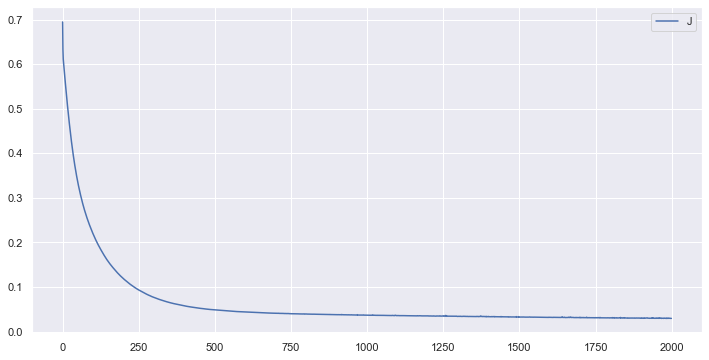

In [76]:
j_history.plot(figsize=(12, 6))

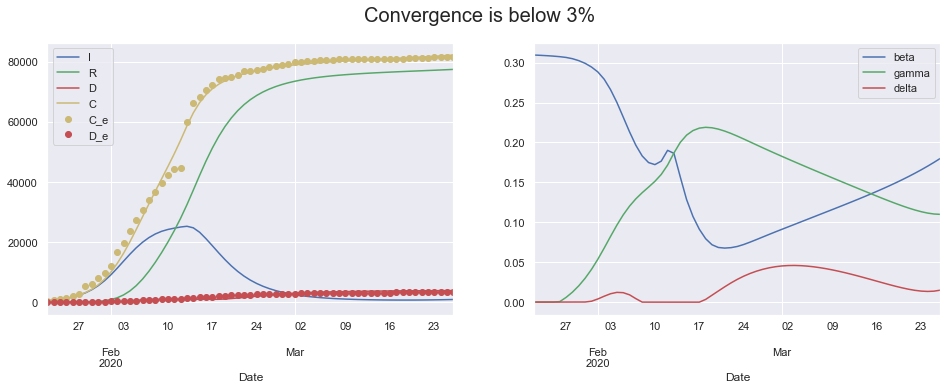

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Convergence is below 3%', size=20)
res[['I', 'R', 'D', 'C', 'C_e', 'D_e']].plot(ax=axes[0], style=['-', 'g-', 'r-', 'y-', 'yo', 'ro'])
_ = res[['beta', 'gamma', 'delta']].plot(ax=axes[1], style=['b', 'g', 'r'])

## Conclusion
The model is converging correctly, however there are differences between my results and the Author. Those differences are probably due to the IC of the system such us the values of $q0$.
Further investigation of why $\gamma$ and $\delta$ are vanishing at the beginning of the pandemic is needed.